In [ ]:
%%capture
!pip install --upgrade matplotlib #relevant as colab's default version doesnt support bar_label attribute
# Restart the kernel automatically with upgraded matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/STTM

/content/gdrive/MyDrive/STTM


In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import re
import time
import warnings
import csv
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from tqdm.notebook import tqdm
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf
from keras import backend as K 
from tensorflow import keras


inspect which GPU is allocated for the task

In [ ]:
!nvidia-smi

Tue Jun 14 14:38:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"

training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [ ]:
len(train_corpus)

14703

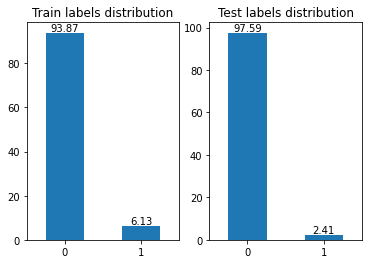

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (pd.Series(train_labels).value_counts()/len(train_labels)*100).round(2).plot(kind='bar',title='Train labels distribution',ax= ax1)
ax.bar_label(ax1.containers[0])
ax = (pd.Series(test_labels).value_counts()/len(test_labels)*100).round(2).plot(kind='bar',title='Test labels distribution',ax=ax2)
ax.bar_label(ax2.containers[0])
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)
plt.show()

# Building a classifier for classifying the predator / victim inside the conversation

We feed one document per author per conversation. This means if an author partook in multiple conversations we will have multiple documents for that author. The benefit of this is this would better reflect the type of data in real-world and have more labeled data for training purposes

In [ ]:
def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        # only get suspicious conversations
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(0)
    return corpus, labels

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_train_file_path = 'data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path))
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

In [ ]:
len(train_corpus), len(test_corpus)

(1808, 5608)

In [ ]:
pd.Series(train_labels).value_counts()

0    907
1    901
dtype: int64

In [ ]:
pd.Series(test_labels).value_counts()

1    3723
0    1885
dtype: int64

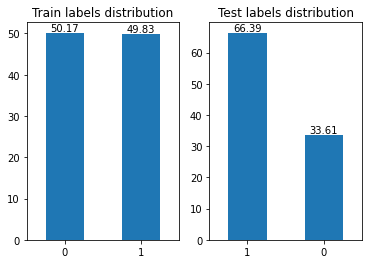

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (pd.Series(train_labels).value_counts()/len(train_labels)*100).round(2).plot(kind='bar',title='Train labels distribution',ax= ax1)
ax.bar_label(ax1.containers[0])
ax = (pd.Series(test_labels).value_counts()/len(test_labels)*100).round(2).plot(kind='bar',title='Test labels distribution',ax=ax2)
ax.bar_label(ax2.containers[0])
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)
plt.show()

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    pred_name = file.split('.xml')[0].lower()
    corpus_pj.append(" ".join(df[df['USERNAME'].str.contains(pred_name,case=False)].BODY.tolist()))
    labels_pj.append(1)
    corpus_pj.append(" ".join(df[~df['USERNAME'].str.contains(pred_name,case=False)].BODY.tolist()))
    labels_pj.append(0)

In [ ]:
len(labels_pj)

112

In [ ]:
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
y_test_pj = np.array(labels_pj)

## Applying TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
# vectorizer = TfidfVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))
print("Training label shape: {}".format(y_train.shape))
print("Testing label shape: {}".format(y_test.shape))

Training data shape: (1808, 120616)
Testing data shape: (5608, 120616)
Training data shape: (1808, 120616)
Testing data shape: (5608, 120616)
Training label shape: (1808,)
Testing label shape: (5608,)


#LightGBM model classification

In [ ]:
import lightgbm as lgb
modelgbm = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
modelgbm.fit(X_train, y_train)
pred_y = modelgbm.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))
# try on PJ dataset:
pred_y = modelgbm.predict(X_test_pj)
print(metrics.accuracy_score(y_test_pj, pred_y))
np.unique(pred_y,return_counts=True)

0.8215049928673324
0.9285714285714286


(array([0, 1]), array([54, 58]))

# XGBoost model classification

In [ ]:
np.random.seed(12)
model_b = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False, learning_rate = 0.3, n_estimators=1000, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = model_b.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  79.56490727532098
Accuracy on PJ test dataset:  91.96428571428571


(array([0, 1]), array([53, 59]))

# Applying SVM 

Linear support

In [ ]:
#SVM
model_linear = LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)
model_linear.fit(X_train, y_train)
pred_y = model_linear.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_linear.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  86.32310984308131
Accuracy on PJ test dataset:  91.96428571428571


(array([0, 1]), array([51, 61]))

C-Support Vector

In [ ]:
# linear kernel SVM 
model_svc = svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)
model_svc.fit(X_train, y_train)
pred_y = model_svc.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_svc.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  86.28744650499287
Accuracy on PJ test dataset:  91.96428571428571


(array([0, 1]), array([51, 61]))

# SVM improvemets

In [ ]:
#eclf = VotingClassifier(estimators=[('linear', xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)), ('svc', model_svc),])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf = VotingClassifier(estimators=[('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)), ('svc', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True))],voting='soft', weights=[1, 1])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf.fit(X_train, y_train)
pred_y =eclf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# X_test_pj = vectorizer.transform(corpus_pj)
# X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
# X_test_pj =X_test_pj
# y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = eclf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  84.87874465049929
Accuracy on PJ test dataset:  92.85714285714286


(array([0, 1]), array([52, 60]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
    ('sv,', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)),
     ('svtwo', LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)),
     ('xgb',xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)),
      ('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42))]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
pred_y =clf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
pred_y = clf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  86.39443651925819
Accuracy on PJ test dataset:  91.96428571428571


(array([0, 1]), array([51, 61]))

# Applying DeepNN

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf

In [ ]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [ ]:
# # vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer()

# # PAN12 data
# X_train = vectorizer.fit_transform(train_corpus).astype('float16')
# X_test = vectorizer.transform(test_corpus).astype('float16')
# y_train = np.array(train_labels)
# y_test = np.array(test_labels)
# ##pj -data 
# X_test_pj = vectorizer.transform(corpus_pj).astype('float16')
# y_test_pj = np.array(labels_pj)

In [ ]:
# Model Training 
print ("Create model ... ")
def build_model(shape):
    K.clear_session()
    np.random.seed(12)
    python_random.seed(12)
    tf.random.set_seed(12)
    model = Sequential()
    model.add(Dense(256, input_dim=shape, activation='relu'))
    # model.add(Dense(256, input_dim=121394, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

print("Compile model ...")
modeldnn = build_model(X_train.shape[1])

Create model ... 
Compile model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               30877952  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               51400     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 160)               32160     
                                                                 
 dropout_2 (Dropout)         (None, 160)               0         
                                                                 
 dense_3 (Dense)    

In [ ]:
# Train model
modeldnn.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])
modeldnn.fit(X_train.astype('float16'), y_train, batch_size=64, shuffle="batch",
                epochs=3)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


29/29 [==============================] - 1s 22ms/step - loss: 0.6795 - accuracy: 0.6322
Epoch 2/3
29/29 [==============================] - 1s 22ms/step - loss: 0.2431 - accuracy: 0.9364
Epoch 3/3
29/29 [==============================] - 1s 22ms/step - loss: 0.0207 - accuracy: 0.9945


In [ ]:
pred_y = modeldnn.predict(X_test.astype('float16'))
pred_y =np.round(pred_y.flatten())
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)

Accuracy on PAN12 test dataset:  90.99500713266761


In [ ]:
pred_y = modeldnn.predict(X_test_pj.astype('float16'))
pred_y =np.round(pred_y.flatten())
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj,pred_y)*100)

Accuracy on PJ test dataset:  91.96428571428571


Saving the models above

In [ ]:
pickle.dump(modelgbm, open('lgbm_pred.sav', 'wb')) # to load: loaded_model = pickle.load(open(filename, 'rb'))
pickle.dump(model_b, open('xgb_pred.sav', 'wb'))
pickle.dump(model_svc, open('svc_pred.sav', 'wb'))
pickle.dump(eclf, open('voting_pred.sav', 'wb'))
pickle.dump(clf, open('stacking_pred.sav', 'wb'))
modeldnn.save('dnn_pred')

# Classifying using Transformers

## finetune API for text classification
built upon TensorFlow & Keras

In [ ]:
%%capture
!pip install --quiet finetune

In [ ]:
%%capture
import finetune as ft

In [ ]:
from finetune.base_models import RoBERTa,TextCNN

In [ ]:
txtcnn_pred = ft.Classifier(base_model=TextCNN,chunk_long_sequences=True, n_epochs=3) # chunk_long_sequences flag moves a sliding window of length max_length across the input, and takes the mean of the feature representations from the windows
txtcnn_pred.fit(train_corpus, train_labels)
txtcnn_pred.save(path ='txtcnn_pred')

Epoch 3/3: 100%|██████████| 1808/1808 [00:25<00:00, 69.98it/s]


In [ ]:
roberta_pred = ft.Classifier(base_model=RoBERTa,chunk_long_sequences=True, n_epochs=7) # chunk_long_sequences flag moves a sliding window of length max_length across the input, and takes the mean of the feature representations from the windows
roberta_pred.fit(train_corpus, train_labels)
roberta_pred.save(path ='roberta_pred')

Epoch 7/7: 100%|██████████| 2118/2118 [03:13<00:00, 10.92it/s]


## Plot the results

# Load all trained models

In [ ]:
modelgbm = pickle.load(open('lgbm_pred.sav', 'rb'))# pickle.dump(modelgbm, open('lgbm.sav', 'wb')) # to load: loaded_model = pickle.load(open(filename, 'rb'))
model_b = pickle.load(open('xgb_pred.sav', 'rb'))# pickle.dump(model_b, open('xgb.sav', 'wb'))
model_svc = pickle.load(open('svc_pred.sav', 'rb'))# pickle.dump(model_svc, open('svc.sav', 'wb'))
eclf = pickle.load(open('voting_pred.sav', 'rb'))# pickle.dump(eclf, open('voting.sav', 'wb'))
clf = pickle.load(open('stacking_pred.sav', 'rb'))# pickle.dump(clf, open('stacking.sav', 'wb'))
modeldnn =  keras.models.load_model('dnn_pred')
bertmodel = ft.Classifier.load('roberta_pred')
txtcnn = ft.Classifier.load('txtcnn_pred')

In [ ]:
%%capture
### save accuracy on pj dataset

acc1_pj=  metrics.accuracy_score(y_test_pj, modelgbm.predict(X_test_pj ))*100

acc2_pj=  metrics.accuracy_score(y_test_pj, model_b.predict(X_test_pj))*100

acc3_pj=  metrics.accuracy_score(y_test_pj, model_svc.predict(X_test_pj))*100

acc4_pj=  metrics.accuracy_score(y_test_pj, eclf.predict(X_test_pj))*100

acc5_pj=  metrics.accuracy_score(y_test_pj, clf.predict(X_test_pj))*100

acc6_pj=  metrics.accuracy_score(y_test_pj, np.round(modeldnn.predict(X_test_pj.astype('float16')).flatten()))*100

y_pred_bert = bertmodel.predict(corpus_pj)
acc7_pj = metrics.accuracy_score(labels_pj,y_pred_bert)*100

y_pred_txtcnn = txtcnn.predict(corpus_pj)
acc8_pj  = metrics.accuracy_score(labels_pj, y_pred_txtcnn)*100 #textcnn

acc_pj = ['PervJust Accuracy',acc1_pj,acc2_pj,acc3_pj,acc4_pj,acc5_pj,acc6_pj,acc7_pj,acc8_pj]

In [ ]:
acc_pj

['PervJust Accuracy',
 92.85714285714286,
 91.96428571428571,
 91.96428571428571,
 92.85714285714286,
 91.96428571428571,
 91.96428571428571,
 98.21428571428571,
 96.42857142857143]

In [ ]:
%%time
inf_time_list = ['Inference Time [Min]']
t = time.time()
acc1=  metrics.accuracy_score(y_test, modelgbm.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc2=  metrics.accuracy_score(y_test, model_b.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc3=  metrics.accuracy_score(y_test, model_svc.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc4=  metrics.accuracy_score(y_test, eclf.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc5=  metrics.accuracy_score(y_test, clf.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc6=  metrics.accuracy_score(y_test, np.round(modeldnn.predict(X_test.astype('float16')).flatten()))*100
inf_time_list.append((time.time() - t)/60)


CPU times: user 19.3 s, sys: 331 ms, total: 19.6 s
Wall time: 19.2 s


In [ ]:
t = time.time()
y_pred_bert = bertmodel.predict(test_corpus)
acc7 = metrics.accuracy_score(test_labels,y_pred_bert)*100
inf_time_list.append((time.time() - t)/60)


Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
t = time.time()
y_pred_txtcnn = txtcnn.predict(test_corpus)
acc8  = metrics.accuracy_score(test_labels, y_pred_txtcnn)*100 #textcnn
inf_time_list.append((time.time() - t)/60)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 5608it [00:32, 174.85it/s]


In [ ]:
with open('inf_time_list_pred.pkl', 'wb') as f:
  pickle.dump(inf_time_list, f)
f.close()
accuracy_list = ['Accuracy',acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8]
with open('accuracy_list_pred.pkl', 'wb') as f:
  pickle.dump(accuracy_list, f)
f.close()
with open('acc_pj_pred.pkl', 'wb') as f:
  pickle.dump(acc_pj, f)
f.close()

In [ ]:
inf_time_list =pickle.load(open('inf_time_list_pred.pkl', 'rb'))
accuracy_list = pickle.load(open('accuracy_list_pred.pkl', 'rb'))
acc_pj = pickle.load(open('acc_pj_pred.pkl', 'rb'))

In [ ]:
y_pred_prob1 = modelgbm.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc1 = roc_auc_score(y_test, y_pred_prob1)

y_pred_prob2 = model_b.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
auc2 = roc_auc_score(y_test, y_pred_prob2)


y_pred_prob3 = model_svc.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 =  roc_curve(y_test, y_pred_prob3)
auc3 = roc_auc_score(y_test, y_pred_prob3)

y_pred_prob4 = eclf.predict_proba(X_test)[:,1] 
fpr4 , tpr4, thresholds4 =  roc_curve(y_test, y_pred_prob4)
auc4 = roc_auc_score(y_test, y_pred_prob4)


y_pred_prob5 = clf.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 =  roc_curve(y_test, y_pred_prob5)
auc5 = roc_auc_score(y_test, y_pred_prob5)

y_pred_prob6 = (modeldnn.predict(X_test)).flatten()
fpr6 , tpr6, thresholds6 =  roc_curve(y_test, y_pred_prob6)
auc6 = roc_auc_score(y_test, y_pred_prob6)

y_pred_prob7 = bertmodel.predict_proba(test_corpus)
y_pred_prob7 = [val[1] for val in y_pred_prob7]
fpr7 , tpr7, thresholds7 =  roc_curve(test_labels, y_pred_prob7)
auc7 = roc_auc_score(test_labels, y_pred_prob7)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
tpf_fpr_auc =[(fpr1 , tpr1,auc1),(fpr2 , tpr2,auc2),(fpr3 , tpr3,auc3),(fpr4 , tpr4,auc4),(fpr5 , tpr5,auc5),(fpr6 , tpr6,auc6),(fpr7 , tpr7,auc7)]

In [ ]:
with open('tpf_fpr_auc_1_7_pred.pkl', 'wb') as f:
  pickle.dump(tpf_fpr_auc , f)
f.close()

In [ ]:
tpf_fpr_auc=   pickle.load(open('tpf_fpr_auc_1_7_pred.pkl', 'rb'))

In [ ]:
y_pred_prob8 = txtcnn.predict_proba(test_corpus)
y_pred_prob8 = [val[1] for val in y_pred_prob8]
fpr8 , tpr8, thresholds8 =  roc_curve(test_labels, y_pred_prob8)
auc8 = roc_auc_score(test_labels, y_pred_prob8)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 5608it [00:32, 173.67it/s]


In [ ]:
tpf_fpr_auc.append((fpr8 , tpr8,auc8))
with open('tpf_fpr_auc_1_8_pred.pkl', 'wb') as f:
  pickle.dump(tpf_fpr_auc , f)
f.close()

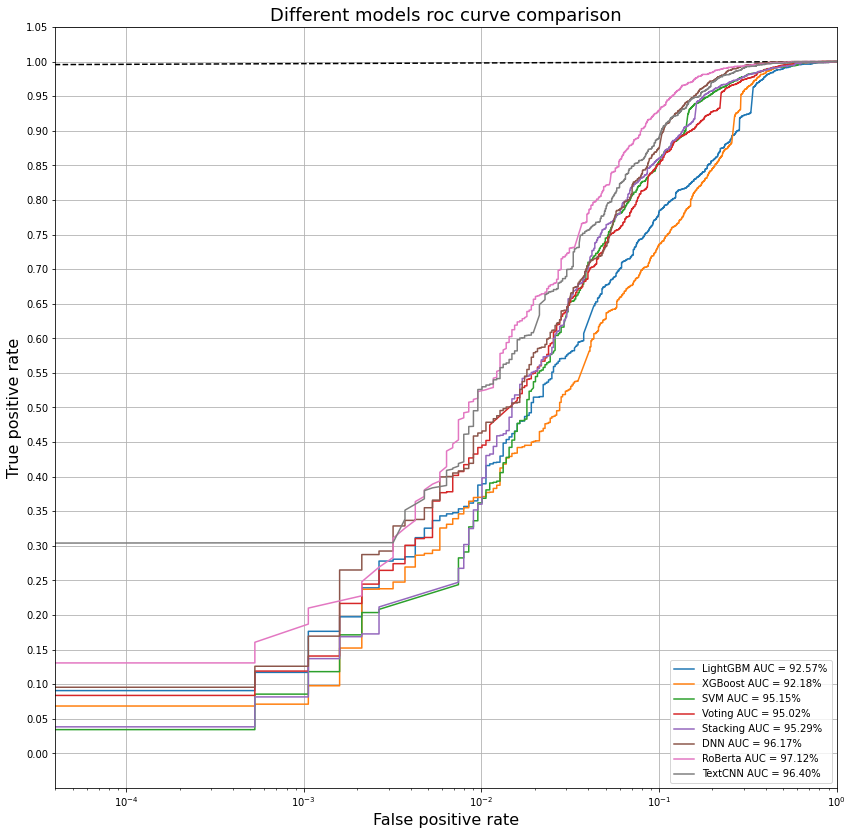

In [ ]:
# tpf_fpr_auc =[(fpr1 , tpr1,auc1)
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height
plt.plot([0,1],[0,1], 'k--')
plt.plot(tpf_fpr_auc[0][0], tpf_fpr_auc[0][1], label= f"LightGBM AUC = {100*tpf_fpr_auc[0][2] :.2f}%")
plt.plot(tpf_fpr_auc[1][0], tpf_fpr_auc[1][1], label= f"XGBoost AUC = {100*tpf_fpr_auc[1][2] :.2f}%")
plt.plot(tpf_fpr_auc[2][0], tpf_fpr_auc[2][1], label= f"SVM AUC = {100*tpf_fpr_auc[2][2] :.2f}%")
plt.plot(tpf_fpr_auc[3][0], tpf_fpr_auc[3][1], label= f"Voting AUC = {100*tpf_fpr_auc[3][2] :.2f}%")
plt.plot(tpf_fpr_auc[4][0], tpf_fpr_auc[4][1], label= f"Stacking AUC = {100*tpf_fpr_auc[4][2] :.2f}%")
plt.plot(tpf_fpr_auc[5][0], tpf_fpr_auc[5][1], label= f"DNN AUC = {100*tpf_fpr_auc[5][2] :.2f}%")
plt.plot(tpf_fpr_auc[6][0], tpf_fpr_auc[6][1], label= f"RoBerta AUC = {100*tpf_fpr_auc[6][2] :.2f}%")
plt.plot(tpf_fpr_auc[7][0], tpf_fpr_auc[7][1], label= f"TextCNN AUC = {100*tpf_fpr_auc[7][2] :.2f}%")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate",fontsize=16)
plt.title('Different models roc curve comparison',fontsize=18)
plt.legend(loc= 'lower right')
plt.show()

# Accuracy and detection rates

In [ ]:
dat=pd.DataFrame(data= [accuracy_list,
                        ['AUC',tpf_fpr_auc[0][2]*100,tpf_fpr_auc[1][2]*100,tpf_fpr_auc[2][2]*100,tpf_fpr_auc[3][2]*100,tpf_fpr_auc[4][2]*100,tpf_fpr_auc[5][2]*100,tpf_fpr_auc[6][2]*100,tpf_fpr_auc[7][2]*100],
                        ['0.1% FPR Detection',
                        tpf_fpr_auc[0][1][np.abs(tpf_fpr_auc[0][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[1][1][np.abs(tpf_fpr_auc[1][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[2][1][np.abs(tpf_fpr_auc[2][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[3][1][np.abs(tpf_fpr_auc[3][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[4][1][np.abs(tpf_fpr_auc[4][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[5][1][np.abs(tpf_fpr_auc[5][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[6][1][np.abs(tpf_fpr_auc[6][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[7][1][1] * 100
                         ],
                        ['1% FPR Detection',
                        tpf_fpr_auc[0][1][np.abs(tpf_fpr_auc[0][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[1][1][np.abs(tpf_fpr_auc[1][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[2][1][np.abs(tpf_fpr_auc[2][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[3][1][np.abs(tpf_fpr_auc[3][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[4][1][np.abs(tpf_fpr_auc[4][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[5][1][np.abs(tpf_fpr_auc[5][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[6][1][np.abs(tpf_fpr_auc[6][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[7][1][np.abs(tpf_fpr_auc[7][0]-0.01).argmin()] * 100
                         ],
                        inf_time_list,
                        acc_pj],
                 columns =  ['metric','LightGBM','XGBoost','SVM','Voting','Stacking','DNN','RoBerta','TextCNN'])
dat = dat.set_index('metric')
dat = dat.rename(index={'Accuracy': 'Accuracy on PAN12 test'})

In [ ]:
dat.round(2)

,LightGBM,XGBoost,SVM,Voting,Stacking,DNN,RoBerta,TextCNN
metric,,,,,,,,
Accuracy on PAN12 test,82.15,79.56,86.29,84.88,86.39,91.00,85.79,88.00
AUC,92.57,92.18,95.15,95.02,95.29,96.17,97.12,96.40
0.1% FPR Detection,11.71,7.12,8.57,11.90,8.17,12.60,18.69,30.46
1% FPR Detection,38.79,37.01,36.21,44.21,36.02,46.31,51.33,52.62
Inference Time [Min],0.00,0.00,0.10,0.10,0.10,0.01,1.21,0.53
PervJust Accuracy,92.86,91.96,91.96,92.86,91.96,91.96,98.21,96.43


In [ ]:
dat

,LightGBM,XGBoost,SVM,Voting,Stacking,DNN,RoBerta,TextCNN
metric,,,,,,,,
Accuracy on PAN12 test,82.150499,79.564907,86.287447,84.878745,86.394437,90.995007,85.788160,87.999287
AUC,92.569111,92.179975,95.154994,95.018927,95.290847,96.174828,97.117944,96.401023
0.1% FPR Detection,11.710986,7.117916,8.568359,11.899006,8.165458,12.597368,18.694601,30.459307
1% FPR Detection,38.785925,37.013161,36.207360,44.211657,36.019339,46.306742,51.329573,52.618856
Inference Time [Min],0.004548,0.004311,0.100282,0.097954,0.103102,0.009082,1.208521,0.534857
PervJust Accuracy,92.857143,91.964286,91.964286,92.857143,91.964286,91.964286,98.214286,96.428571


In [ ]:
dat.to_csv('results_df_pred.csv')